In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
from gnnboundary import *
from lib.boundary_thickness import boundary_thickness

In [7]:
import torch

# MOTIF

In [8]:
dataset = MotifDataset(seed=12345)

In [9]:
model = GCNClassifier(node_features=len(dataset.NODE_CLS),
                      num_classes=len(dataset.GRAPH_CLS),
                      hidden_channels=6,
                      num_layers=3)
model.load_state_dict(torch.load('ckpts/motif.pt'))

<All keys matched successfully>

In [10]:
dataset_list_gt = dataset.split_by_class()
dataset_list_pred = dataset.split_by_pred(model)
print(dataset_list_pred)

/home/gilian/miniconda3/envs/gnnboundary/lib/python3.11/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/home/gilian/miniconda3/envs/gnnboundary/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


[MotifDataset(2833), MotifDataset(2928), MotifDataset(2926), MotifDataset(2844)]


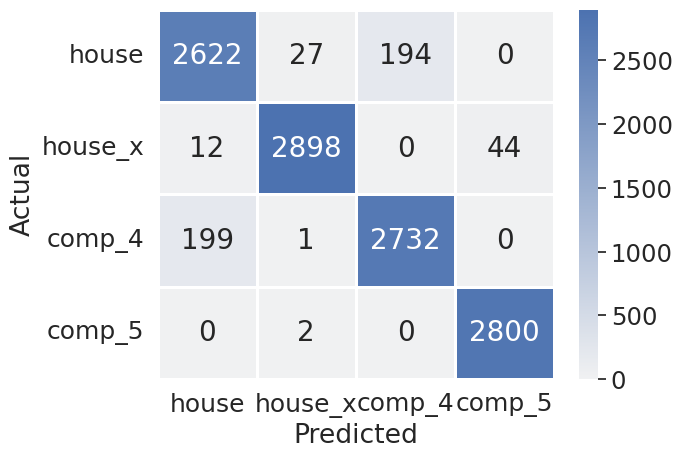

In [7]:
evaluation = dataset.model_evaluate(model)
draw_matrix(evaluation['cm'], dataset.GRAPH_CLS.values(), fmt='d')

In [11]:
mean_embeds = [d.model_transform(model, key="embeds").mean(dim=0) for d in dataset_list_gt]

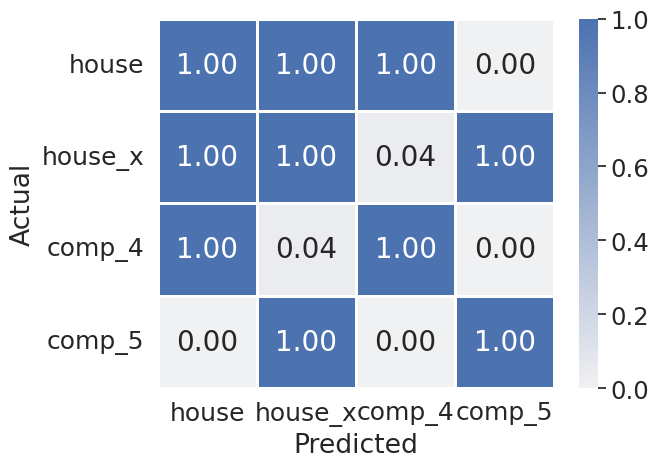

In [9]:
adj_ratio_mat, boundary_info = pairwise_boundary_analysis(model, dataset_list_pred)
draw_matrix(adj_ratio_mat, names=dataset.GRAPH_CLS.values(), fmt='.2f')

In [21]:
from lib.boundary.multi_boundary_analysis import triangular_boundary_analysis

result = triangular_boundary_analysis(model, dataset_list_pred, threshold=0.2)
print(result)

/home/gilian/miniconda3/envs/gnnboundary/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


{}


In [ ]:
thickness = boundary_thickness(graph_embedding, boundary_graph_embedding, model_scoring_function, 0, 1)

In [12]:
trainer = {}
sampler = {}
from lib.trainer import GPUTrainer
from lib.trainer import NewTrainer

# 0 1 2

In [20]:
cls_1, cls_2, cls_3 = 0, 1, 3
trainer[cls_1, cls_2, cls_3] = NewTrainer(
    sampler=(s := GraphSampler(
        max_nodes=25,
        temperature=0.15,
        num_node_cls=len(dataset.NODE_CLS),
        learn_node_feat=True
    )),
    discriminator=model,
    criterion=WeightedCriterion([
        dict(key="logits", criterion=DynamicBalancingBoundaryCriterion(
            classes=[cls_1, cls_2, cls_3], alpha=1, beta=2
        ), weight=25),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_1]), weight=0),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_2]), weight=0),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_3]), weight=0),
        dict(key="logits", criterion=MeanPenalty(), weight=1),
        dict(key="omega", criterion=NormPenalty(order=1), weight=1),
        dict(key="omega", criterion=NormPenalty(order=2), weight=1),
        # dict(key="xi", criterion=NormPenalty(order=1), weight=0),
        # dict(key="xi", criterion=NormPenalty(order=2), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=1), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=2), weight=0),
        dict(key="theta_pairs", criterion=KLDivergencePenalty(binary=True), weight=0),
    ]),
    optimizer=(o := torch.optim.SGD(s.parameters(), lr=1)),
    scheduler=torch.optim.lr_scheduler.ExponentialLR(o, gamma=1),
    dataset=dataset,
    budget_penalty=BudgetPenalty(budget=10, order=2, beta=1),
)

In [ ]:
cls_1, cls_2, cls_3 = 0, 1, 3
p_min = 0.2
p_max = 0.4
trainer[cls_1, cls_2, cls_3].train(
    iterations=2000,
    target_probs={cls_1: (p_min, p_max), cls_2: (p_min, p_max), cls_3: (p_min, p_max)},
    target_size=50,
    w_budget_init=1,
    w_budget_inc=1.1,
    w_budget_dec=0.95,
    k_samples=32
)

  0%|          | 0/2000 [00:00<?, ?it/s]

logits=[4.9012370109558105, -0.242140531539917, 3.0101842880249023, -14.18705940246582]
probs=[0.8644904494285583, 0.005046843085438013, 0.13046272099018097, 4.4342298721744555e-09]
n=25 m=37


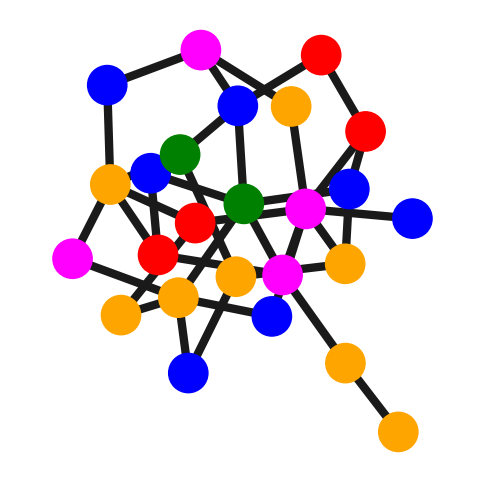

In [19]:
cls_1, cls_2, cls_3 = 0, 1, 2

trainer[cls_1, cls_2, cls_3].evaluate(threshold=0.5, show=True, bernoulli=True)

In [ ]:
res = trainer[cls_1, cls_2, cls_3].quantitative(sample_size=500)
print(res["mean"])
print(res["std"])

# 0 & 1

In [13]:
cls_1, cls_2 = 0, 1
trainer[cls_1, cls_2] = NewTrainer(
    sampler=(s := GraphSampler(
        max_nodes=25,
        temperature=0.15,
        num_node_cls=len(dataset.NODE_CLS),
        learn_node_feat=True
    )),
    discriminator=model,
    criterion=WeightedCriterion([
        dict(key="logits", criterion=DynamicBalancingBoundaryCriterion(
            classes=[cls_1, cls_2], alpha=1, beta=2
        ), weight=25),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_1]), weight=0),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_2]), weight=0),
        dict(key="logits", criterion=MeanPenalty(), weight=1),
        dict(key="omega", criterion=NormPenalty(order=1), weight=1),
        dict(key="omega", criterion=NormPenalty(order=2), weight=1),
        # dict(key="xi", criterion=NormPenalty(order=1), weight=0),
        # dict(key="xi", criterion=NormPenalty(order=2), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=1), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=2), weight=0),
        dict(key="theta_pairs", criterion=KLDivergencePenalty(binary=True), weight=0),
    ]),
    optimizer=(o := torch.optim.SGD(s.parameters(), lr=1)),
    scheduler=torch.optim.lr_scheduler.ExponentialLR(o, gamma=1),
    dataset=dataset,
    budget_penalty=BudgetPenalty(budget=10, order=2, beta=1),
)

In [14]:
cls_1, cls_2 = 0, 1
if trainer[cls_1, cls_2].train(
    iterations=2000,
    target_probs={cls_1: (0.4, 0.6), cls_2: (0.4, 0.6)},
    target_size=40,
    w_budget_init=1,
    w_budget_inc=1.1,
    w_budget_dec=0.95,
    k_samples=16
):
    print("converged")

  0%|          | 0/2000 [00:00<?, ?it/s]

converged


logits=[3.03161883354187, 3.7960236072540283, -5.975578784942627, -7.623542785644531]
probs=[0.31767594814300537, 0.6822776198387146, 3.892315362463705e-05, 7.490426924050553e-06]
n=25 m=35


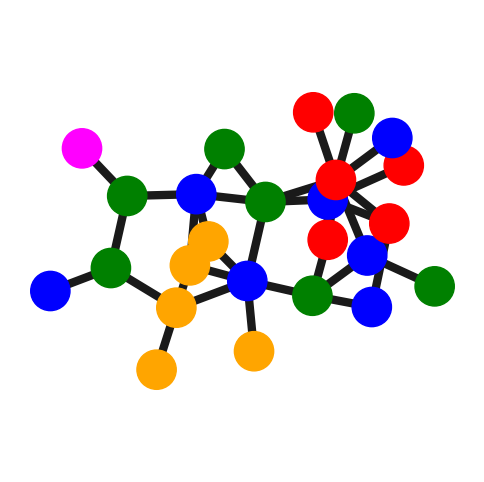

In [15]:
a, b = trainer[0, 1].evaluate(threshold=0.5, show=True, return_probs=True)

In [16]:
res = trainer[0, 1].quantitative(sample_size=1000)

print(res)

{'label': ['house', 'house_x', 'comp_4', 'comp_5'], 'mean': array([4.52099725e-01, 5.47705017e-01, 1.90172209e-04, 5.08558980e-06]), 'std': array([1.25594710e-01, 1.25837260e-01, 3.40179751e-04, 2.00080361e-06])}


# 0 & 2

In [ ]:
cls_1, cls_2 = 0, 2
trainer[cls_1, cls_2] = Trainer(
    sampler=(s := GraphSampler(
        max_nodes=25,
        temperature=0.2,
        num_node_cls=len(dataset.NODE_CLS),
        learn_node_feat=True
    )),
    discriminator=model,
    criterion=WeightedCriterion([
        dict(key="logits", criterion=DynamicBalancingBoundaryCriterion(
            classes=[cls_1, cls_2], alpha=1, beta=2
        ), weight=25),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_1]), weight=1),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_2]), weight=1),
        dict(key="logits", criterion=MeanPenalty(), weight=1),
        dict(key="omega", criterion=NormPenalty(order=1), weight=1),
        dict(key="omega", criterion=NormPenalty(order=2), weight=1),
        # dict(key="xi", criterion=NormPenalty(order=1), weight=0),
        # dict(key="xi", criterion=NormPenalty(order=2), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=1), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=2), weight=0),
        dict(key="theta_pairs", criterion=KLDivergencePenalty(binary=True), weight=5),
    ]),
    optimizer=(o := torch.optim.SGD(s.parameters(), lr=1)),
    scheduler=torch.optim.lr_scheduler.ExponentialLR(o, gamma=1),
    dataset=dataset,
    budget_penalty=BudgetPenalty(budget=10, order=2, beta=1),
)

In [ ]:
cls_1, cls_2 = 0, 2
trainer[cls_1, cls_2].train(
    iterations=2000,
    target_probs={cls_1: (0.4, 0.6), cls_2: (0.4, 0.6)},
    target_size=40,
    w_budget_init=1,
    w_budget_inc=1.1,
    w_budget_dec=0.95,
    k_samples=16
)

In [ ]:
trainer[0, 2].evaluate(threshold=0.5, show=True)

# 1 & 3

In [ ]:
cls_1, cls_2 = 1, 3
trainer[cls_1, cls_2] = Trainer(
    sampler=(s := GraphSampler(
        max_nodes=20,
        temperature=0.2,
        num_node_cls=len(dataset.NODE_CLS),
        learn_node_feat=True
    )),
    discriminator=model,
    criterion=WeightedCriterion([
        dict(key="logits", criterion=DynamicBalancingBoundaryCriterion(
            classes=[cls_1, cls_2], alpha=1, beta=1
        ), weight=25),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_1]), weight=0),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_2]), weight=0),
        dict(key="logits", criterion=MeanPenalty(), weight=2),
        dict(key="omega", criterion=NormPenalty(order=1), weight=1),
        dict(key="omega", criterion=NormPenalty(order=2), weight=1),
        # dict(key="xi", criterion=NormPenalty(order=1), weight=0),
        # dict(key="xi", criterion=NormPenalty(order=2), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=1), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=2), weight=0),
        dict(key="theta_pairs", criterion=KLDivergencePenalty(binary=True), weight=0),
    ]),
    optimizer=(o := torch.optim.SGD(s.parameters(), lr=1)),
    scheduler=torch.optim.lr_scheduler.ExponentialLR(o, gamma=1),
    dataset=dataset,
    budget_penalty=BudgetPenalty(budget=10, order=2, beta=1)
)

In [ ]:
cls_1, cls_2 = 1, 3
trainer[cls_1, cls_2].train(
    iterations=10000,
    target_probs={cls_1: (0.4, 0.6), cls_2: (0.4, 0.6)},
    target_size=60,
    w_budget_init=1,
    w_budget_inc=1.15,
    w_budget_dec=0.98,
    k_samples=16
)

In [ ]:
trainer[1, 3].evaluate(threshold=0.5, show=True)